<a href="https://colab.research.google.com/github/andythetechnerd03/PyTorch_Learning/blob/main/02_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Classification with PyTorch

- Binary classification
- Multi-class Classification
- Multi-label Classification
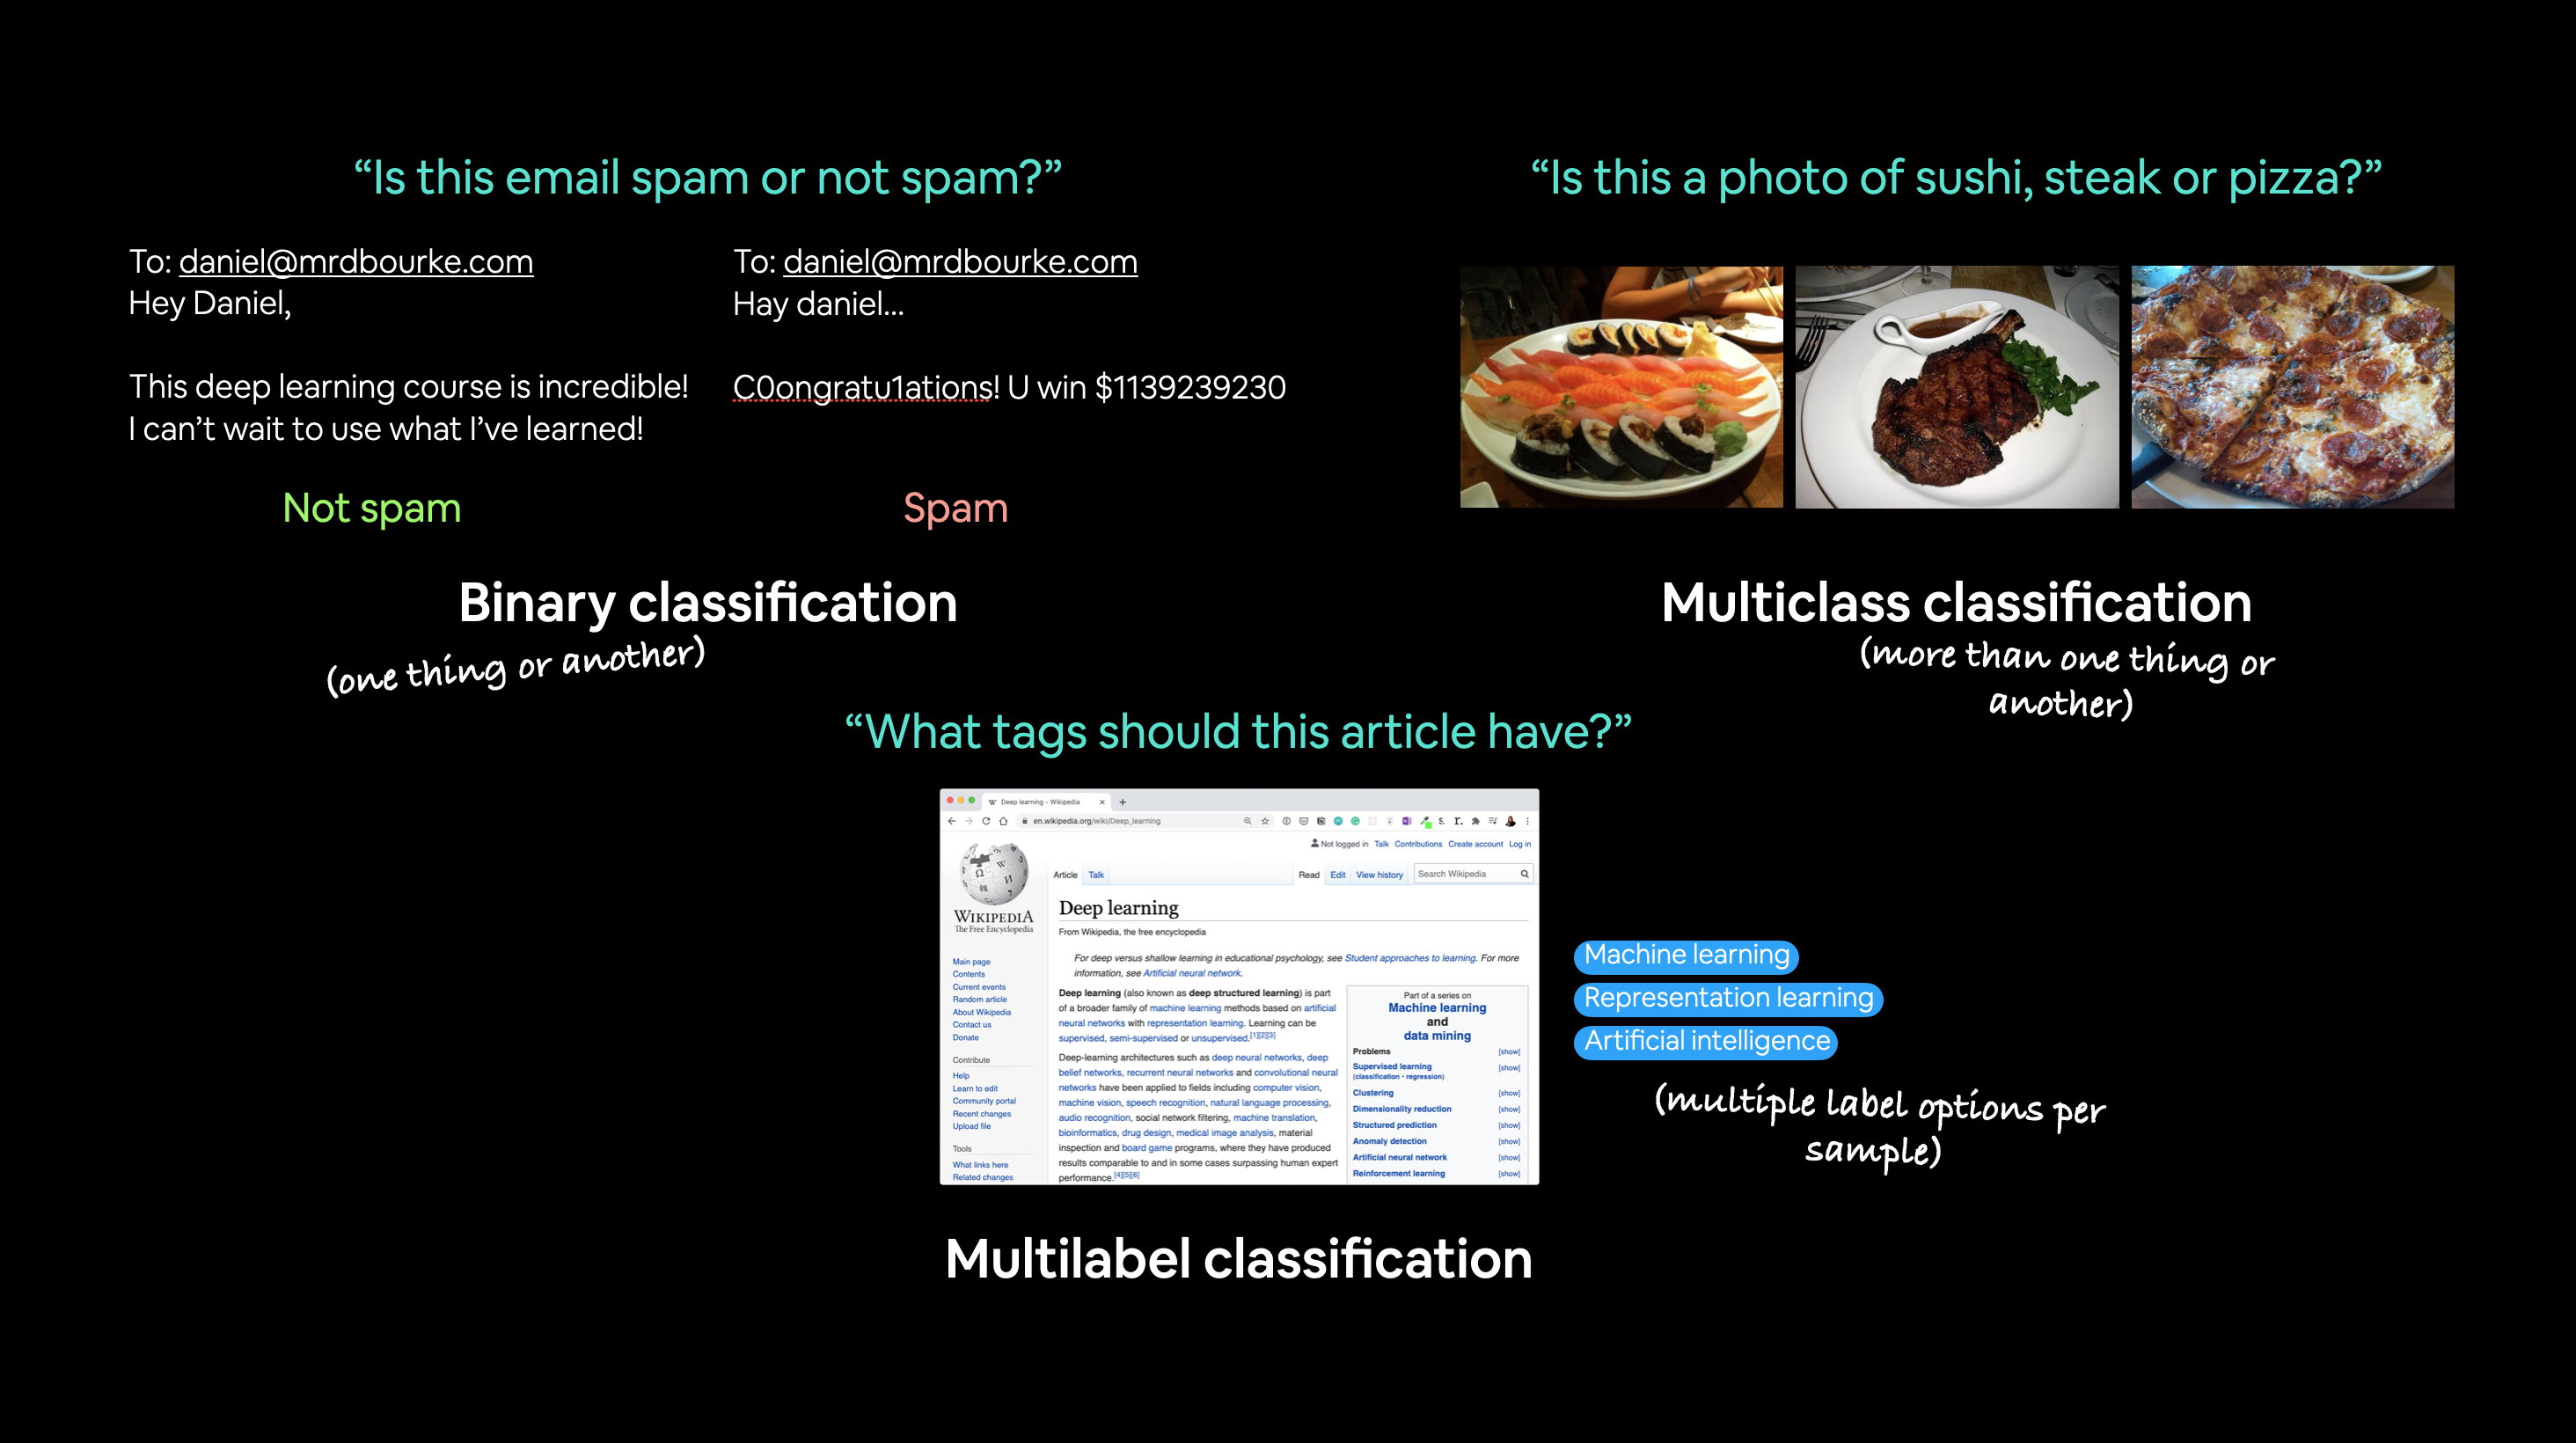

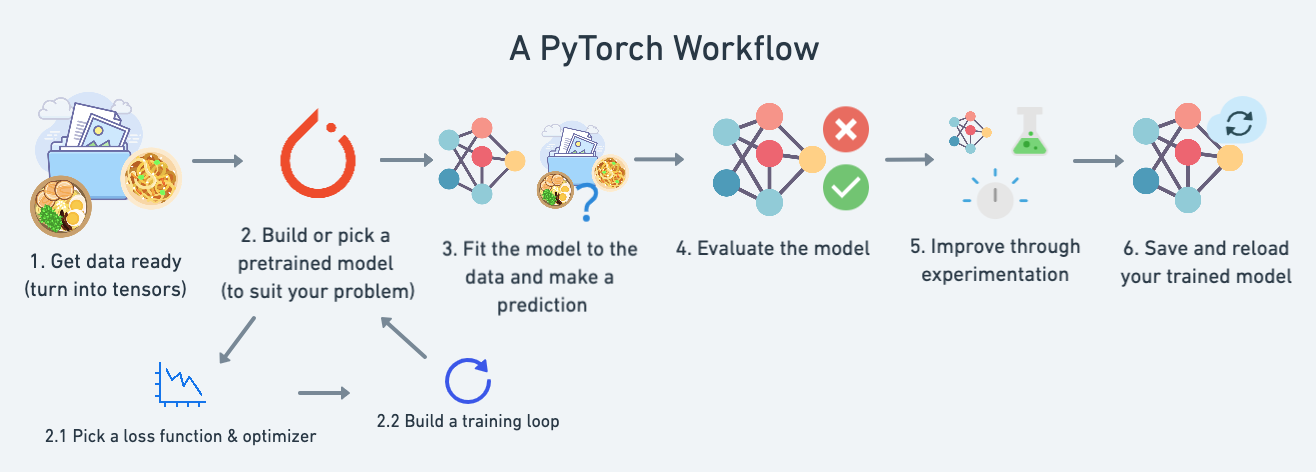

Hyperparameter	Binary Classification	Multiclass classification
Input layer shape (in_features)	Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction)	Same as binary classification
Hidden layer(s)	Problem specific, minimum = 1, maximum = unlimited	Same as binary classification
Neurons per hidden layer	Problem specific, generally 10 to 512	Same as binary classification
Output layer shape (out_features)	1 (one class or the other)	1 per class (e.g. 3 for food, person or dog photo)
Hidden layer activation	Usually ReLU (rectified linear unit) but can be many others	Same as binary classification
Output activation	Sigmoid (torch.sigmoid in PyTorch)	Softmax (torch.softmax in PyTorch)
Loss function	Binary crossentropy (torch.nn.BCELoss in PyTorch)	Cross entropy (torch.nn.CrossEntropyLoss in PyTorch)
Optimizer	SGD (stochastic gradient descent), Adam (see torch.optim for more options)	Same as binary classification

## 0. Architecture of a NN

## 1. Make classification data

In [13]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise
                    random_state=42) # manual seed

Let's view the first 5 values of `X` and `y`

In [14]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


Bring the dataset to a `pandas DataFrame`

In [15]:
import pandas as pd

circles = pd.DataFrame({
    "X1": X[:,0],
    "X2": X[:,1],
    "label": y
})

circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


How balanced is the dataset?

In [16]:
circles['label'].value_counts()

1    500
0    500
Name: label, dtype: int64

<Axes: >

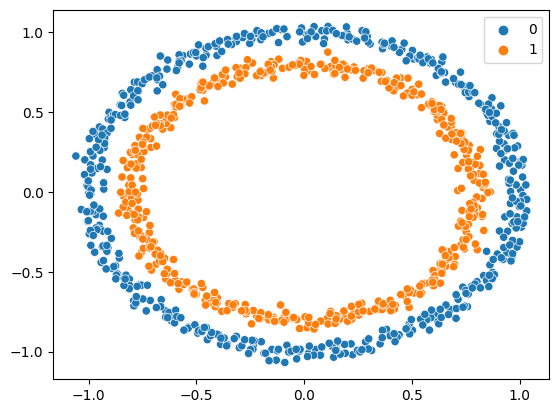

In [17]:
import seaborn as sns

sns.scatterplot(x=X[:,0],
            y=X[:,1],
            hue=y)

### Input and Output shapes

In [18]:
X.shape, y.shape

((1000, 2), (1000,))

In [19]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### Turn data into tensors and split into training and testing sets

In [20]:
# Turn data into tensors
# Must do
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first 5 samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

Split the data into train/test with `ratio=0.8` (80% training, 20% testing) and `random_state=42`

In [21]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

We've got some data ready, now it's time to build a model.

We'll break it down into a few parts.

1. Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
2. Constructing a model by subclassing `nn.Module`.
3. Defining a loss function and optimizer.
4. Creating a training loop (this'll be in the next section).
The good news is we've been through all of the above steps before in notebook 01.

Except now we'll be adjusting them so they work with a classification dataset.

Let's start by importing PyTorch and `torch.nn` as well as setting up device agnostic code.

In [22]:
# Imports
import torch
from torch import nn

# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Let's create a model class that:

- Subclasses nn.Module (almost all PyTorch models are subclasses of nn.Module).
- Creates 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
- Defines a forward() method containing the forward pass computation of the model.
- Instantiates the model class and sends it to the target device.

In [23]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # inputs x
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # outputs y

  # 3. Define a forward() method containing the forward pass computation
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # Return the output of layer_2, the same shape as y
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> y_hat

# 4. Instantiate a model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

You can do the same using `nn.Sequential()`

In [24]:
# Replicate CircleModelV0 with nn.Sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
).to(device)

In [25]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Steup loss function and optimizer

PyTorch has two binary cross entropy implementations:

1. `torch.nn.BCELoss()` - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
2. `torch.nn.BCEWithLogitsLoss()` - This is the same as above except it has a sigmoid layer (`nn.Sigmoid`) built-in (we'll see what this means soon).

Which one should you use?

The documentation for `torch.nn.BCEWithLogitsLoss()` states that it's more numerically stable than using `torch.nn.BCELoss()` after a `nn.Sigmoid` layer.

So generally, implementation 2 is a better option. However for advanced usage, you may want to separate the combination of `nn.Sigmoid` and `torch.nn.BCELoss()` but that is beyond the scope of this notebook.

Knowing this, let's create a loss function and an optimizer.

For the optimizer we'll use `torch.optim.SGD()` to optimize the model parameters with `learning rate 0.1`.

In [26]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

Accuracy

In [27]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Training loop

In [28]:
a = torch.Tensor([0.2,0.4,0.6,0.8])
torch.sum(a > 0.5)

tensor(2)

In [29]:
torch.manual_seed(42)
threshold = 0.5

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = (torch.sigmoid(y_logits) >= threshold).long() # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69796, Accuracy: 51.88% | Test loss: 0.69440, Test acc: 58.00%
Epoch: 10 | Loss: 0.69590, Accuracy: 51.25% | Test loss: 0.69305, Test acc: 53.00%
Epoch: 20 | Loss: 0.69490, Accuracy: 51.62% | Test loss: 0.69254, Test acc: 49.50%
Epoch: 30 | Loss: 0.69435, Accuracy: 51.12% | Test loss: 0.69236, Test acc: 49.50%
Epoch: 40 | Loss: 0.69401, Accuracy: 50.88% | Test loss: 0.69232, Test acc: 51.00%
Epoch: 50 | Loss: 0.69378, Accuracy: 50.25% | Test loss: 0.69234, Test acc: 50.00%
Epoch: 60 | Loss: 0.69362, Accuracy: 50.00% | Test loss: 0.69239, Test acc: 51.50%
Epoch: 70 | Loss: 0.69351, Accuracy: 50.25% | Test loss: 0.69246, Test acc: 51.00%
Epoch: 80 | Loss: 0.69342, Accuracy: 49.88% | Test loss: 0.69254, Test acc: 50.00%
Epoch: 90 | Loss: 0.69336, Accuracy: 49.88% | Test loss: 0.69262, Test acc: 53.00%


## 4. Make predictions and evaluate the model

In [30]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

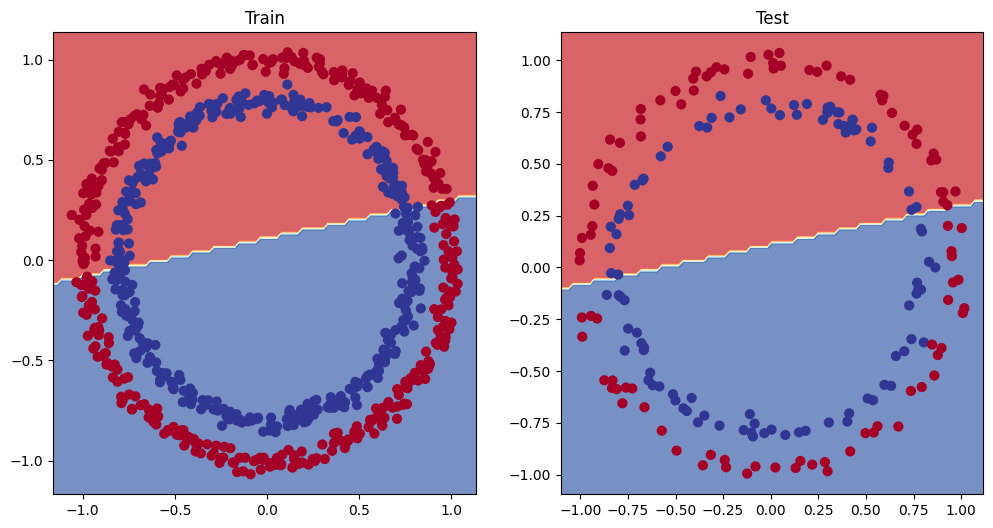

In [31]:
# Plot decision boundaries for training and test sets
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Non-linearity

In [32]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=16)
    self.relu = nn.LeakyReLU() # ReLU activation function
    self.layer2 = nn.Linear(in_features=16, out_features=16)
    self.layer3 = nn.Linear(in_features=16, out_features=1)
    #self.sigmoid = nn.Sigmoid()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.layer1(x)
    x = self.relu(x)
    x = self.layer2(x)
    x = self.relu(x)
    x = self.layer3(x)
    #x = self.sigmoid(x)
    return x

model_3 = CircleModelV1().to(device)
print(model_3)

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
)


In [33]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [34]:
def prob_to_class(y_logits: torch.Tensor,
                  threshold: float) -> torch.Tensor:
  return (y_logits >= threshold).float()

In [35]:
a = torch.Tensor([0.2,0.4,0.6,0.8])
torch.round(a)

tensor([0., 0., 1., 1.])

In [36]:
# Fit the model
torch.manual_seed(42)
epochs = 100
threshold = 0.5

# Put all data on target device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  #model_3.train()
  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = prob_to_class(torch.sigmoid(y_logits), threshold)

  # 2. Calculate loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Gradient descent
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = prob_to_class(torch.sigmoid(test_logits), threshold)
    # 2. Calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch {epoch}: Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch 0: Loss: 0.69750, Accuracy: 50.00% | Test loss: 0.69781, Test Accuracy: 50.00%


In [37]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 1., 0., 1., 1., 0., 0., 0., 0., 1.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

If you use `Sigmoid()` within the model, then the `plot_decision_boundary()` won't work for some reasons, even though the model has very good accuracy score.

Only without `sigmoid()` in the model + `BCEWithLogitsLoss()` will result in a satisfactory visualization.

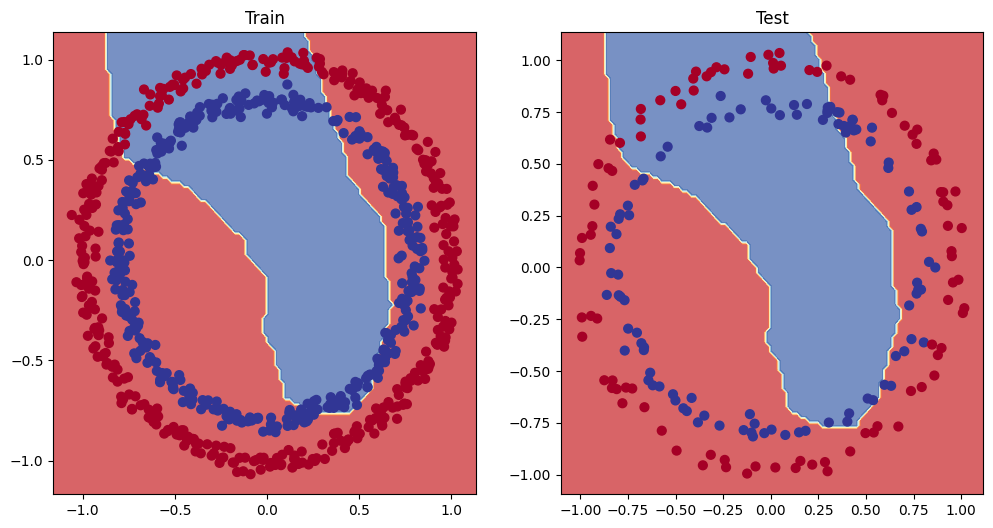

In [38]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## 8. Multi-class Classification

### 8.1. Make classification data

In [39]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [40]:
# Set the hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [41]:
# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state = RANDOM_SEED)

In [42]:
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)
print(X_blob[:5], y_blob[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


In [43]:
# 3. Split into training and testing data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                      y_blob,
                                                      test_size=0.2,
                                                      random_state=RANDOM_SEED)
print(len(X_blob_train), len(X_blob_test))

800 200


<Axes: >

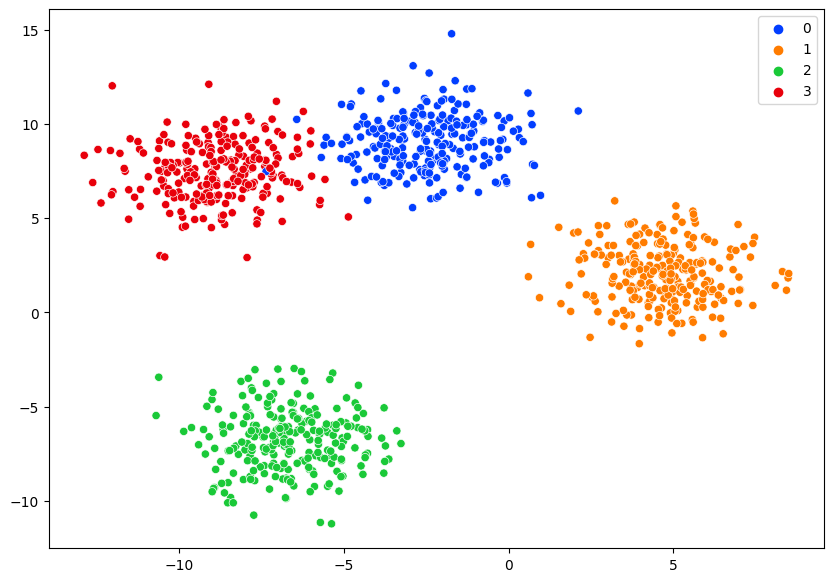

In [44]:
# 4. Plot data
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_blob[:,0], y=X_blob[:,1], hue=y_blob, palette='bright')

### 8.2. Building a multi-class model for classification

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [46]:
from torch import nn

# Build a model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=16):
    super().__init__()
    self.sequential = nn.Sequential(
        nn.Linear(input_features, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units,hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_features)
    )

  def forward(self, x):
    return self.sequential(x)

# Make an instance of the BlobModel
model_4 = BlobModel(input_features=2,
                    output_features=NUM_CLASSES,
                    hidden_units=16).to(device)
model_4

BlobModel(
  (sequential): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
)

### 8.3 Creating a loss function and optimizer for a multi-class PyTorch model


In [47]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1)

### 8.4. Getting prediction probabilites for a multi-class PyTorch model

In [48]:
with torch.inference_mode():
  print(model_4(X_train.to(device))[:5])

tensor([[-0.0997,  0.2285, -0.1396, -0.1509],
        [-0.0948,  0.2290, -0.1614, -0.1569],
        [-0.1747,  0.1312, -0.3328, -0.2520],
        [-0.1852,  0.1345, -0.3271, -0.2523],
        [-0.1723,  0.1416, -0.2880, -0.1078]], device='cuda:0')


In [49]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [50]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.6275, -0.0263,  0.4105, -0.2881],
        [-0.1864, -0.3265, -0.6985, -0.8258],
        [-0.4274, -0.2100, -0.7616, -0.4180],
        [-0.3362,  0.2067,  0.3564, -0.2991],
        [-0.4431, -0.1350, -0.3469,  0.0273]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1418, 0.2587, 0.4004, 0.1991],
        [0.3338, 0.2901, 0.2000, 0.1761],
        [0.2520, 0.3132, 0.1804, 0.2544],
        [0.1737, 0.2989, 0.3472, 0.1802],
        [0.1975, 0.2688, 0.2175, 0.3162]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [51]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1418, 0.2587, 0.4004, 0.1991], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(2, device='cuda:0')


### 8.5. Creating training loop and test loop

In [52]:
# Fit the model
torch.manual_seed(RANDOM_SEED)

# Set the number of epochs
epochs = 1000

# Put the data into the device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  ### Training
  model_4.train()

  # 1. Forward pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=-1).argmax(dim=-1) # go from logits -> probabilities -> classes

  # 2. Compute accuracy
  #print(y_logits.shape, y_blob_train.shape)
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_pred=y_pred, y_true=y_blob_train)

  # 3. Optimizer zero_grad
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Gradient descent
  optimizer.step()

  ### Testing
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=-1).argmax(dim=-1)
    # 2. Calculate the accuracy and loss
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_pred=test_pred, y_true=y_blob_test)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}")


Epoch 0 | Loss: 1.52733, Accuracy: 3.38 | Test Loss: 1.20977, Test Accuracy: 11.50
Epoch 100 | Loss: 0.03324, Accuracy: 99.00 | Test Loss: 0.02480, Test Accuracy: 99.50
Epoch 200 | Loss: 0.02815, Accuracy: 99.00 | Test Loss: 0.01837, Test Accuracy: 99.50
Epoch 300 | Loss: 0.02678, Accuracy: 99.12 | Test Loss: 0.01635, Test Accuracy: 99.50
Epoch 400 | Loss: 0.02608, Accuracy: 99.12 | Test Loss: 0.01530, Test Accuracy: 99.50
Epoch 500 | Loss: 0.02561, Accuracy: 99.12 | Test Loss: 0.01461, Test Accuracy: 99.50
Epoch 600 | Loss: 0.02523, Accuracy: 99.12 | Test Loss: 0.01411, Test Accuracy: 99.50
Epoch 700 | Loss: 0.02491, Accuracy: 99.12 | Test Loss: 0.01370, Test Accuracy: 99.50
Epoch 800 | Loss: 0.02462, Accuracy: 99.12 | Test Loss: 0.01335, Test Accuracy: 99.50
Epoch 900 | Loss: 0.02435, Accuracy: 99.12 | Test Loss: 0.01304, Test Accuracy: 99.50


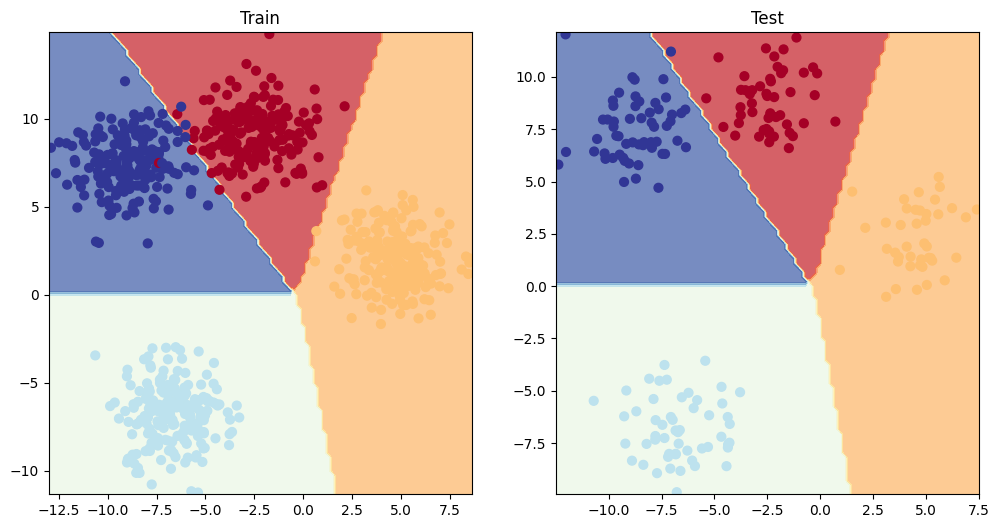

In [53]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

You can do confusion matrix

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
with torch.inference_mode():
  predictions = torch.softmax(model_4(X_blob_test), dim=-1).argmax(dim=-1)
cm = confusion_matrix(y_blob_test, predictions, labels = list(range(NUM_CLASSES)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=list(range(NUM_CLASSES)))
disp.plot()
plt.show()

RuntimeError: ignored

## 9. More classification metrics
Accuracy, Precision, Recall, F1-Score, Confusion Matrix

In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(torch.softmax(model_4(X_blob_test), dim=-1).argmax(dim=-1), y_blob_test)

Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_blob_test,
                            y_pred = predictions))

## Exercises (CS231n)

In [1]:
import torch
import torch.nn

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

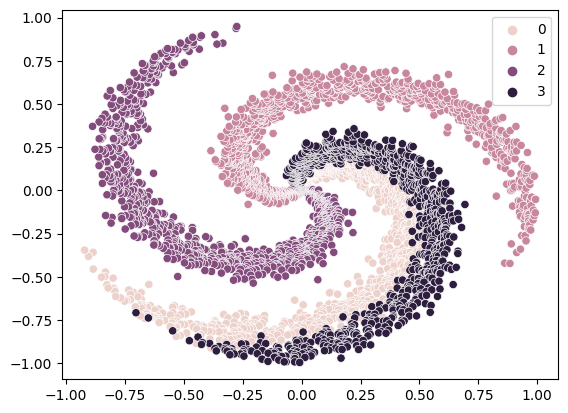

In [104]:
torch.manual_seed(42)
# Code for creating a spiral dataset from CS231n
import matplotlib.pyplot as plt
import numpy as np
N = 1000 # number of points per class
D = 2 # dimensionality
K = 4 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
plt.show()

In [85]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.long)
X.shape, y.shape

(torch.Size([4000, 2]), torch.Size([4000]))

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.2,
                                                    random_state = 42)
X_train, X_test, y_train, y_test = (X_train.to(device),
                X_test.to(device),
                y_train.to(device), y_test.to(device))

In [87]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([3200, 2]),
 torch.Size([3200]),
 torch.Size([800, 2]),
 torch.Size([800]))

In [88]:
class SpiralModel(nn.Module):
  def __init__(self,in_features=2, hidden_features=16, out_features=4):
    super().__init__()
    self.stack = nn.Sequential(
        nn.Linear(in_features, hidden_features),
        nn.ReLU(),
        nn.Linear(hidden_features, hidden_features),
        nn.ReLU(),
        nn.Linear(hidden_features, out_features)
    )
  def forward(self, x):
    return self.stack(x)

model = SpiralModel(in_features = D, out_features = K).to(device)
model

SpiralModel(
  (stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [89]:
next(model.parameters()).device

device(type='cuda', index=0)

In [92]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Declare constants

LEARNING_RATE = 0.01
NUM_EPOCHS = 1000
BATCH_SIZE = 16
THRESHOLD = 0.5


# Declare optim and loss
loss_fn = nn.CrossEntropyLoss()

optim = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop and test loop (using mini-batches)
for epoch in range(NUM_EPOCHS):
  # Put the model in training mode
  model.train()

  # Forward pass
  y_logits = model(X_train)
  y_pred = torch.softmax(y_logits, dim=-1).argmax(dim=-1).squeeze()

  # Calculate loss and accuracy
  train_loss = loss_fn(y_logits,y_train)
  train_acc = accuracy_fn(y_pred,y_train)

  # Gradient descent
  optim.zero_grad()
  train_loss.backward()
  optim.step()

  # Go on test mode
  with torch.inference_mode():
    test_logits = model(X_test)
    test_pred = torch.softmax(test_logits, dim=-1).argmax(dim=-1).squeeze()
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch {epoch}: Train loss: {train_loss}, Train Acc: {train_acc}, Test loss: {test_loss}, Test acc: {test_acc}")





Epoch 0: Train loss: 1.3777996301651, Train Acc: 18.78125, Test loss: 1.368074893951416, Test acc: 25.624999999999996
Epoch 1: Train loss: 1.3633472919464111, Train Acc: 24.03125, Test loss: 1.356359839439392, Test acc: 32.0
Epoch 2: Train loss: 1.351393699645996, Train Acc: 33.1875, Test loss: 1.3468611240386963, Test acc: 32.625
Epoch 3: Train loss: 1.3413937091827393, Train Acc: 33.84375, Test loss: 1.3369746208190918, Test acc: 33.375
Epoch 4: Train loss: 1.3308005332946777, Train Acc: 35.5625, Test loss: 1.3260300159454346, Test acc: 34.125
Epoch 5: Train loss: 1.3192417621612549, Train Acc: 36.15625, Test loss: 1.314023733139038, Test acc: 34.375
Epoch 6: Train loss: 1.3065557479858398, Train Acc: 36.0625, Test loss: 1.3012422323226929, Test acc: 34.625
Epoch 7: Train loss: 1.2930858135223389, Train Acc: 36.5, Test loss: 1.2877578735351562, Test acc: 37.375
Epoch 8: Train loss: 1.2789733409881592, Train Acc: 37.4375, Test loss: 1.2737218141555786, Test acc: 37.875
Epoch 9: Train 

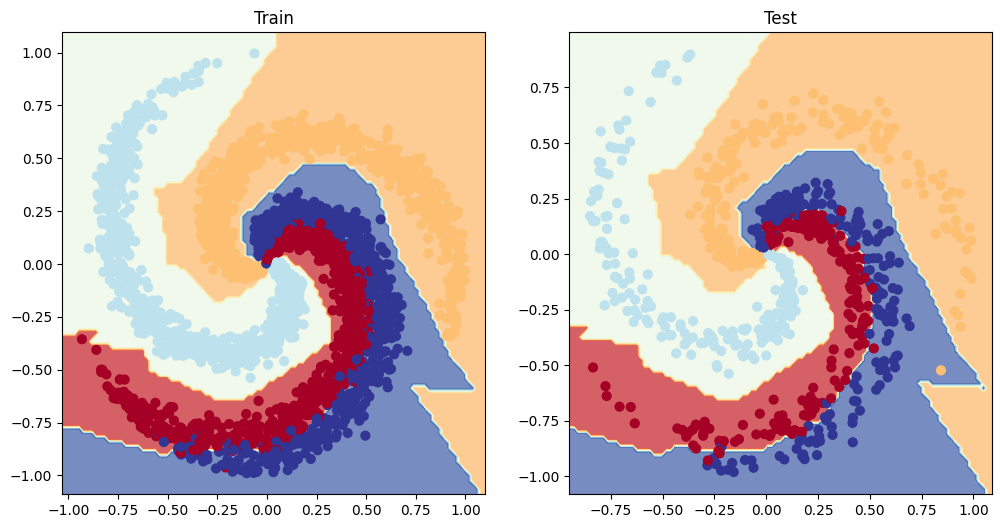

In [93]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

In [99]:
next(model.parameters()).device

device(type='cpu')

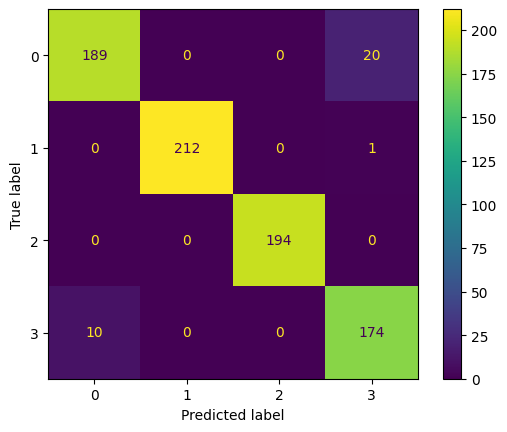

In [101]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model.cuda()
with torch.inference_mode():
  predictions = torch.softmax(model(X_test), dim=-1).argmax(dim=-1)
cm = confusion_matrix(y_test.cpu(), predictions.cpu(), labels = list(range(NUM_CLASSES)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=list(range(NUM_CLASSES)))
disp.plot()
plt.show()